In [ ]:
!pip install wandb einops pytorch-lightning

In [3]:
import copy
import wandb
import torch
import einops
from torch import nn
from PIL import Image
import pytorch_lightning as pl
from functools import lru_cache
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import datasets, models

In [ ]:
wandb.login()

In [5]:
pl.seed_everything(42)
project = 'dino'
max_epochs = 10
batch_size = 64

# ----------------------------------------
# vit hyperparams
in_channels = 3
img_size = 256
patch_size = 32 # large img_size and small patch_size gives a better model and finer attention maps but requires a lot of compute
vit_emb_dim = 128
vit_depth = 4 # 6
heads = 8
vit_hidden_dim = 128

# ----------------------------------------
# dino hyperparams
local_crop_limit = 0.4
global_crop_limit = 0.5
proj_hidden_dim = 128 # 256
out_dim = 128 # 65336
proj_num_layers = 2 # 4
student_temp = 0.9
teacher_temp = 0.04
beta_ma = 0.9
center_beta_ma = 0.9
lr = 3e-4

Global seed set to 42


In [6]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, img_size, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.transform = T.Compose([
                    T.Resize((img_size, img_size)),
                    T.ToTensor()
        ])
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.CIFAR10(self.data_dir, train=True, download=True)

    def setup(self, stage=None):
        if stage in ('fit', None):
            self.train_data = datasets.CIFAR10(self.data_dir, train=True, transform=self.transform)

    @lru_cache(maxsize=128)
    def get_dataloader(self, data):
        return DataLoader(data, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

    def train_dataloader(self):
        return self.get_dataloader(self.train_data)

In [7]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.fc1 = nn.Linear(dim, dim*3)
        self.fc2 = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        qkv = self.fc1(x)
        q, k, v = einops.rearrange(qkv, "b n (qkv h d) -> qkv b h n d", qkv=3, h=self.heads)
        attn = torch.einsum("bhid,bhjd->bhij", q, k) * self.scale
        attn = attn.softmax(dim=-1)
        
        out = torch.einsum("bhij,bhjd->bhid", attn, v)
        out = einops.rearrange(out, "b h n d -> b n (h d)")
        out = self.dropout(self.fc2(out))
        return out, attn

In [8]:
class Block(nn.Module):
    def __init__(self, dim, heads, hidden_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.mhsa = MultiHeadSelfAttention(dim, heads)
        self.ln2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        attn_out, attn = self.mhsa(self.ln1(x))
        x = attn_out + x
        x = self.mlp(self.ln2(x)) + x
        return x, attn

In [9]:
class Transformer(nn.Module):
    def __init__(self, depth, dim, heads, hidden_dim):
        super().__init__()
        self.blocks = nn.ModuleList([Block(dim, heads, hidden_dim) for _ in range(depth)])
            
    def forward(self, x):
        attns = []
        for block in self.blocks:
            x, attn = block(x)
            attns.append(attn)
        return x, torch.stack(attns, dim=1)

In [10]:
class VisionTransformer(nn.Module):
    def __init__(self, in_channels, img_size, patch_size, vit_emb_dim, vit_depth, heads, vit_hidden_dim):
        super().__init__()
        assert img_size % patch_size == 0, 'img_size must be divisible by patch_size!!'
        num_patches = (img_size // patch_size) ** 2
        
        self.patch_embedding = nn.Conv2d(in_channels, vit_emb_dim, patch_size, stride=patch_size)
        self.cls_tokens = nn.Parameter(torch.zeros(1, 1, vit_emb_dim))
        self.pos_embedding = nn.Parameter(torch.empty(1, (num_patches + 1), vit_emb_dim))
        nn.init.normal_(self.pos_embedding, std=0.02)

        self.dropout = nn.Dropout(0.1)
        self.transformer = Transformer(vit_depth, vit_emb_dim, heads, vit_hidden_dim)
        self.ln = nn.LayerNorm(vit_emb_dim)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = einops.rearrange(x, 'b c h w -> b (h w) c')

        cls_tokens = self.cls_tokens.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding

        x = self.dropout(x)
        x, attn = self.transformer(x)
        x = self.ln(x)
        x = x[:, 0]
        return x, attn

In [11]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers):
        super().__init__()
        layers = []
        for _ in range(num_layers - 1):
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.GELU()
            ])
            in_dim = hidden_dim
        self.layers = nn.Sequential(*layers)
        self.fc_out = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        x = self.layers(x)
        x = F.normalize(x, p=2, dim=1, eps=1e-6)
        x = self.fc_out(x)
        return x

In [12]:
class ModelWrapper(nn.Module):
    def __init__(self, model, img_size, proj_hidden_dim, out_dim, proj_num_layers):
        super().__init__()
        self.base = model
        # for a resnet-like model
        # self.base = nn.Sequential(
        #     *list(model.children())[:-1]
        # )
        base_out_dim = self.get_base_out_dim(img_size)
        self.head = MLP(base_out_dim, proj_hidden_dim, out_dim, proj_num_layers)
    
    @torch.no_grad()
    def get_base_out_dim(self, img_size):
        x = torch.randn(1, 3, img_size, img_size)
        x.requires_grad = False
        base_out = self.get_embnattn(x)[0]
        base_out_dim = base_out.shape[-1]
        return base_out_dim

    def get_embnattn(self, x):
        emb, attn = self.base(x)
        return emb, attn

    def forward(self, x):
        emb, _ = self.get_embnattn(x)
        proj = self.head(emb)
        return proj

In [13]:
class DINO(nn.Module):
    def __init__(self, model, img_size, local_crop_limit, global_crop_limit, proj_hidden_dim, out_dim,
                 proj_num_layers, student_temp, teacher_temp, beta_ma, center_beta_ma):
        super().__init__()
        self.augmentation = T.Compose([
            T.RandomApply(
                [T.ColorJitter(0.8, 0.8, 0.8, 0.2)],
                p = 0.3
            ),
            T.RandomGrayscale(p=0.2),
            T.RandomHorizontalFlip(),
            T.RandomApply(
                [T.GaussianBlur((3, 3), (1.0, 2.0))],
                p = 0.2
            ),
            T.RandomResizedCrop((img_size, img_size)),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        self.local_crop = T.RandomResizedCrop((img_size, img_size), scale=(0.05, local_crop_limit))
        self.global_crop = T.RandomResizedCrop((img_size, img_size), scale=(global_crop_limit, 1.0))

        self.student = ModelWrapper(model, img_size, proj_hidden_dim, out_dim, proj_num_layers)
        self.teacher = copy.deepcopy(self.student)
        for p in self.teacher.parameters():
            p.requires_grad = False

        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.register_buffer('t_centers', torch.randn(1, out_dim))
        self.register_buffer('new_t_centers',  torch.zeros(1, out_dim))
        self.center_beta_ma = center_beta_ma
        self.beta_ma = beta_ma

    def loss_fn(self, t_logits, s_logits):
        t_logits = t_logits.detach()
        t_logits = ((t_logits - self.t_centers) / self.teacher_temp).softmax(1)
        s_logits = (s_logits / self.student_temp).softmax(1)
        loss = - (t_logits * (s_logits + 1e-20).log()).sum(1).mean()
        return loss

    # do this at the end of every step after backprop
    @torch.no_grad()
    def update_emas(self):
        # updating teacher params
        for t_params, s_params in zip(self.teacher.parameters(), self.student.parameters()):
            t_params.data = self.beta_ma * t_params.data + (1 - self.beta_ma) * s_params.data

        # updating teacher centers
        self.t_centers = self.center_beta_ma * self.t_centers + (1 - self.center_beta_ma) * self.new_t_centers

    def learn(self, x):
        view1, view2 = self.augmentation(x), self.augmentation(x)
        lc1, lc2 = self.local_crop(view1), self.local_crop(view2)
        gc1, gc2 = self.global_crop(view1), self.global_crop(view2)

        s_logits1, s_logits2 = self.student(lc1), self.student(lc2)
        with torch.no_grad():
            t_logits1, t_logits2 = self.teacher(gc1), self.teacher(gc2)
        loss = (self.loss_fn(t_logits1, s_logits1) + self.loss_fn(t_logits2, s_logits2)) / 2
        self.new_t_centers = torch.cat([t_logits1, t_logits2]).mean(0)
        return loss

    def forward(self, x):
        emb, attn = self.student.get_embnattn(x)
        return emb, attn

In [14]:
class DINOModel(pl.LightningModule):
    def __init__(self, model, img_size, local_crop_limit, global_crop_limit, proj_hidden_dim, out_dim,
                 proj_num_layers, student_temp, teacher_temp, beta_ma, center_beta_ma, lr):
        super().__init__()
        self.model = DINO(model, img_size, local_crop_limit, global_crop_limit, proj_hidden_dim, out_dim,
                          proj_num_layers, student_temp, teacher_temp, beta_ma, center_beta_ma)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
        
    def training_step(self, batch, batch_idx):
        x, _ = batch
        loss = self.model.learn(x)
        self.log(f'train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

In [15]:
class UpdateEMAs(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        pl_module.model.update_emas()

In [16]:
cifar10_dm = CIFAR10DataModule('data/', img_size, batch_size)
# resnet = models.resnet50()
vit = VisionTransformer(in_channels, img_size, patch_size, vit_emb_dim, vit_depth, heads, vit_hidden_dim)
dino_model = DINOModel(vit, img_size, local_crop_limit, global_crop_limit, proj_hidden_dim, out_dim,
                       proj_num_layers, student_temp, teacher_temp, beta_ma, center_beta_ma, lr)

In [17]:
wandb_logger = pl.loggers.WandbLogger(project=project)
trainer = pl.Trainer(max_epochs=max_epochs, gpus=1, precision=16, logger=wandb_logger,
                     log_every_n_steps=50, deterministic=True, callbacks=[UpdateEMAs()])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [18]:
trainer.fit(dino_model, datamodule=cifar10_dm)


Extracting data/cifar-10-python.tar.gz to data/


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: zer0sh0t (use `wandb login --relogin` to force relogin)



  | Name  | Type | Params
-------------------------------
0 | model | DINO | 1.7 M 
-------------------------------
833 K     Trainable params
833 K     Non-trainable params
1.7 M     Total params
6.667     Total estimated model params size (MB)


In [19]:
wandb.finish()

train_loss_step,0.3806
epoch,9
trainer/global_step,7819
_runtime,1106
_timestamp,1626760771
_step,165
train_loss_epoch,0.20739


train_loss_step,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▂▁▁▁▁▁▂▁▁


In [20]:
@torch.no_grad()
def plot_attn(img_path, transform=cifar10_dm.transform, model=dino_model, patch_size=patch_size, layer_idx=-1, heads=8, n_rows=3, n_cols=3):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    img = img.to(model.device)
    emb, attn = model(img)
    img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()

    attn = attn[0, layer_idx]
    feat_size = int((attn.shape[1] - 1) ** 0.5) # ignoring the [CLS] token
    attn = attn[:, 0, 1:].view(heads, feat_size, feat_size) # [0, 1:] -> taking the [CLS] token row and ignoring its inner product with itself
    attn = F.interpolate(attn.unsqueeze(0), scale_factor=patch_size, mode='nearest').squeeze(0)
    attn = attn.cpu().numpy()

    fig = plt.figure(figsize=(40, 40))
    ax = fig.add_subplot(n_rows, n_cols, 1)
    ax.imshow(img)
    ax.axis('off')
    for i in range(0, heads):
        ax = fig.add_subplot(n_rows, n_cols, i+2)
        ax.imshow(attn[i], cmap='inferno')
        ax.axis('off')

    plt.show()
    plt.close()

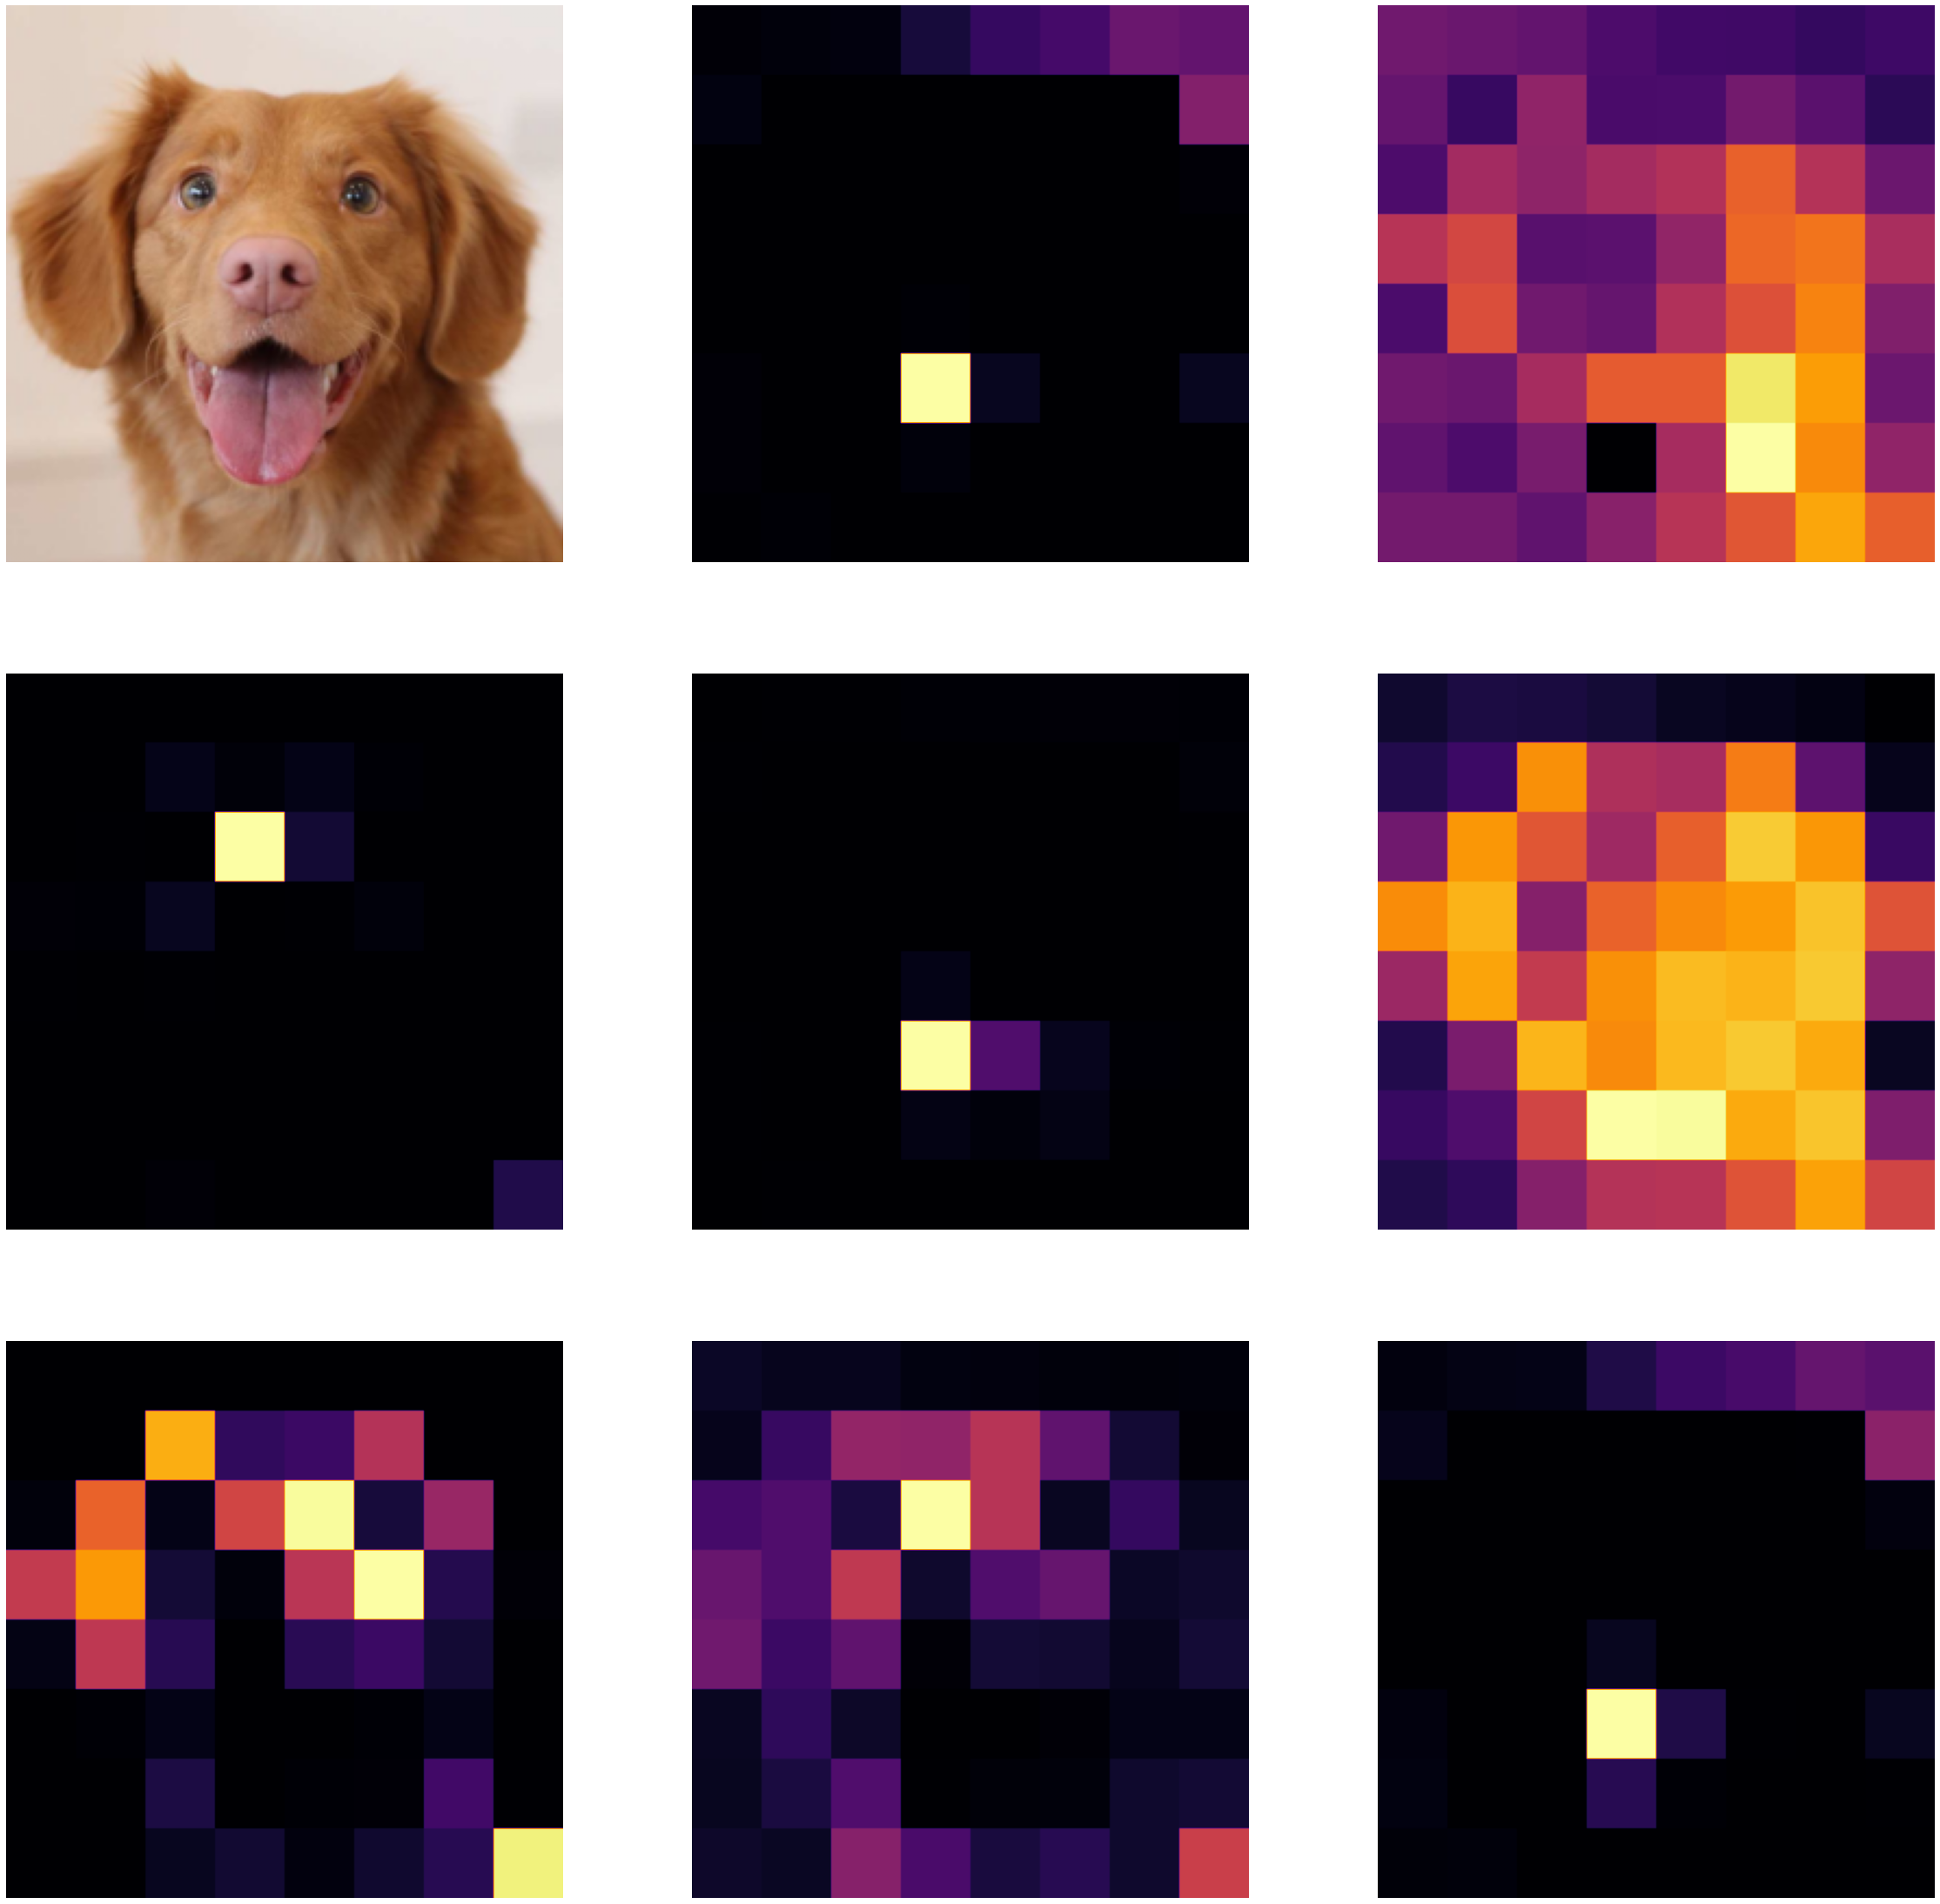

In [21]:
plot_attn('dog.jpg')

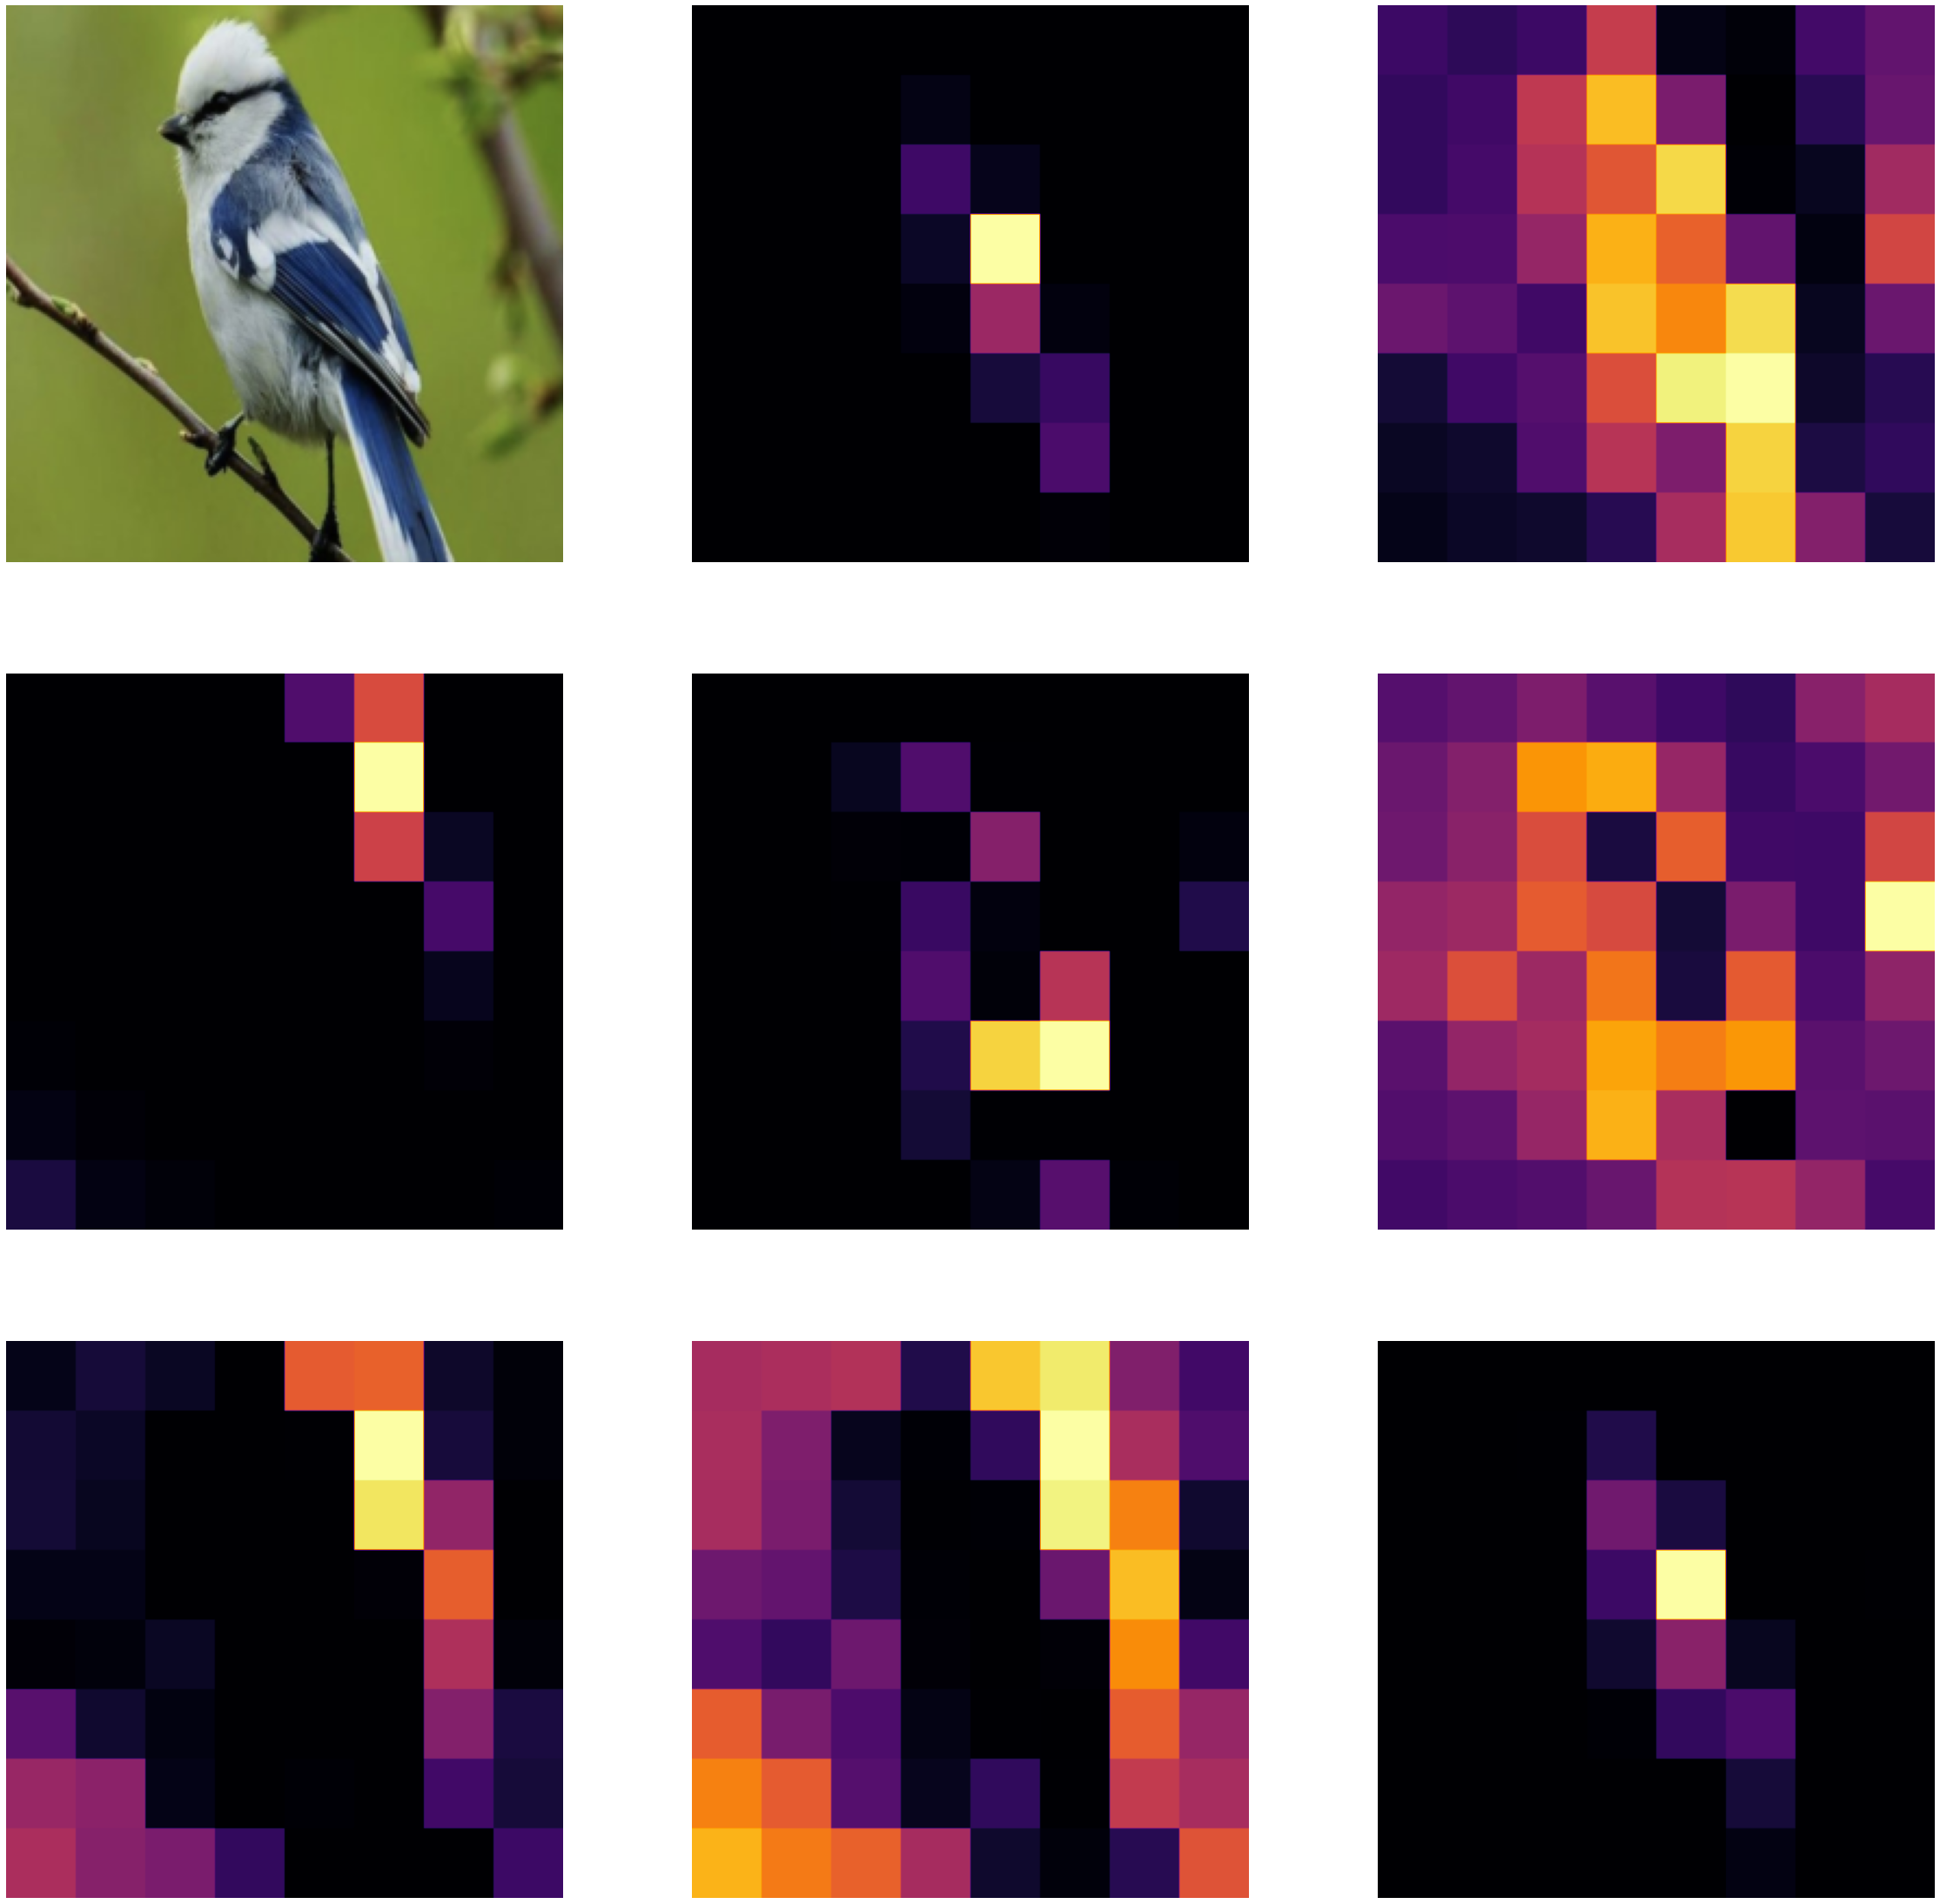

In [22]:
plot_attn('bird.jpg')

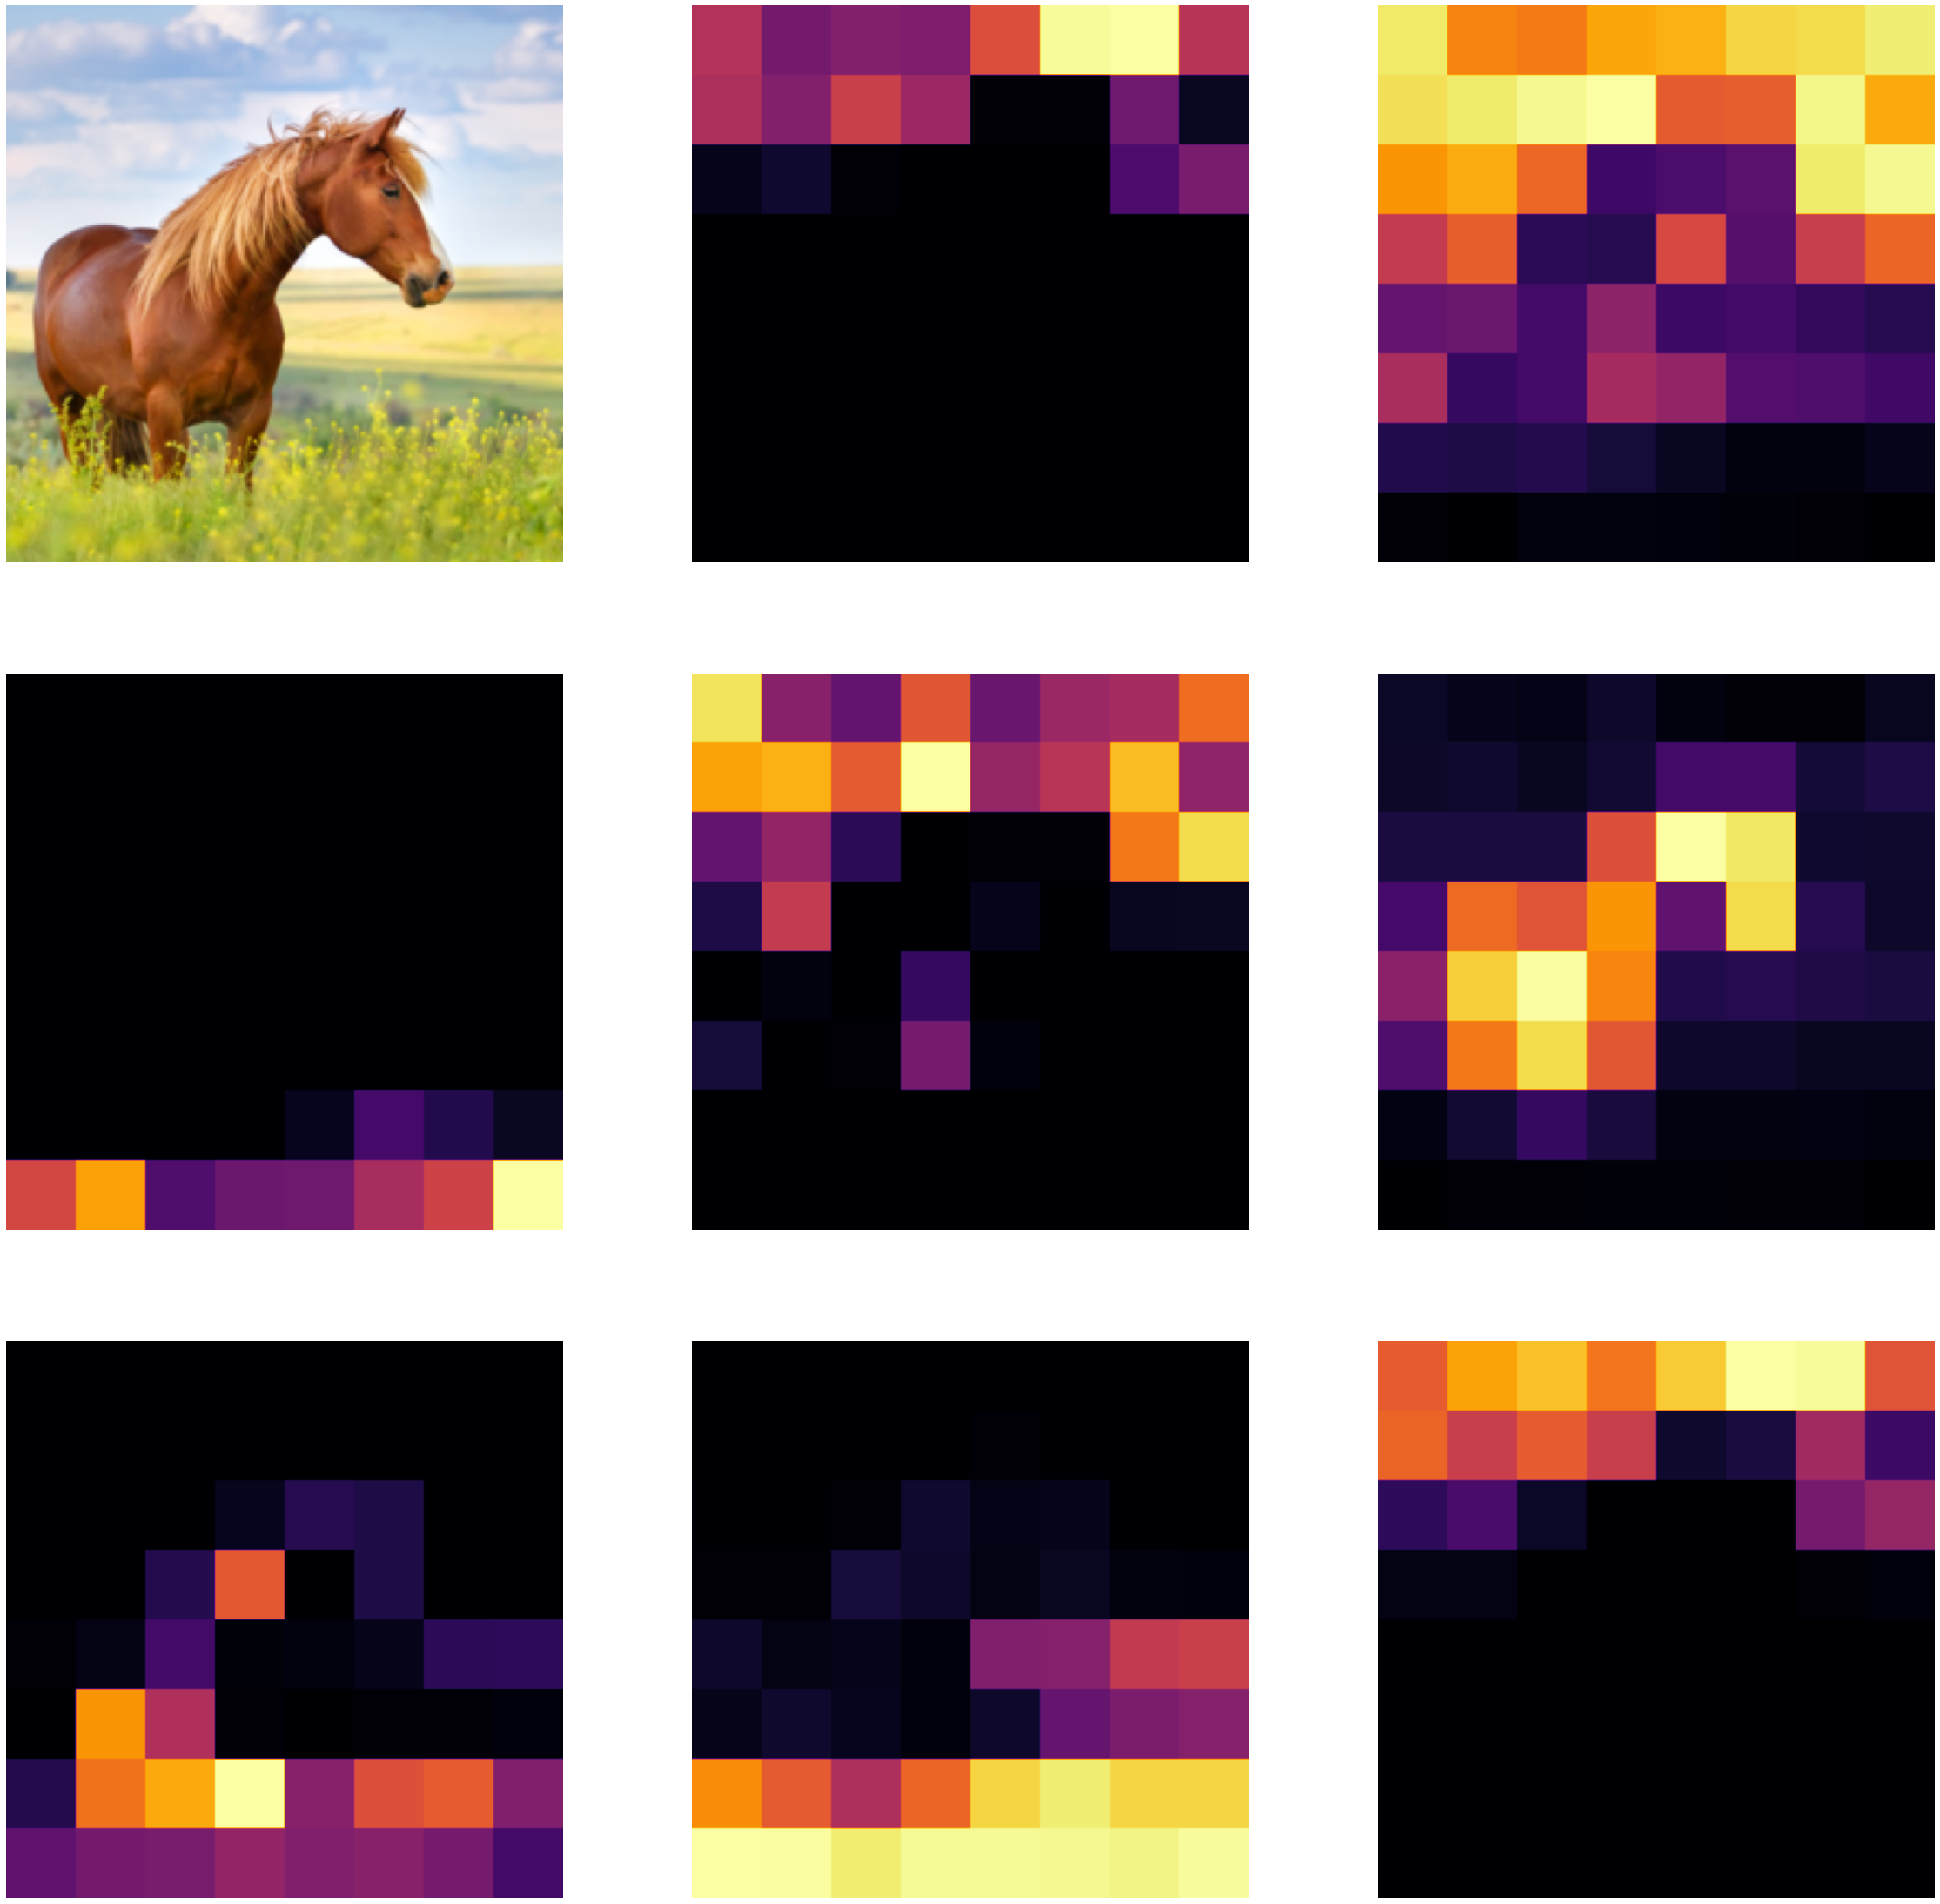

In [23]:
plot_attn('horse.png')

In [24]:
# to get finer attention maps train the model with larger img_size and smaller patch_size
patch_size = 8
new_vit = VisionTransformer(in_channels, img_size, patch_size, vit_emb_dim, vit_depth, heads, vit_hidden_dim)
new_dino_model = DINOModel(new_vit, img_size, local_crop_limit, global_crop_limit, proj_hidden_dim, out_dim,
                           proj_num_layers, student_temp, teacher_temp, center_beta_ma, beta_ma, lr)

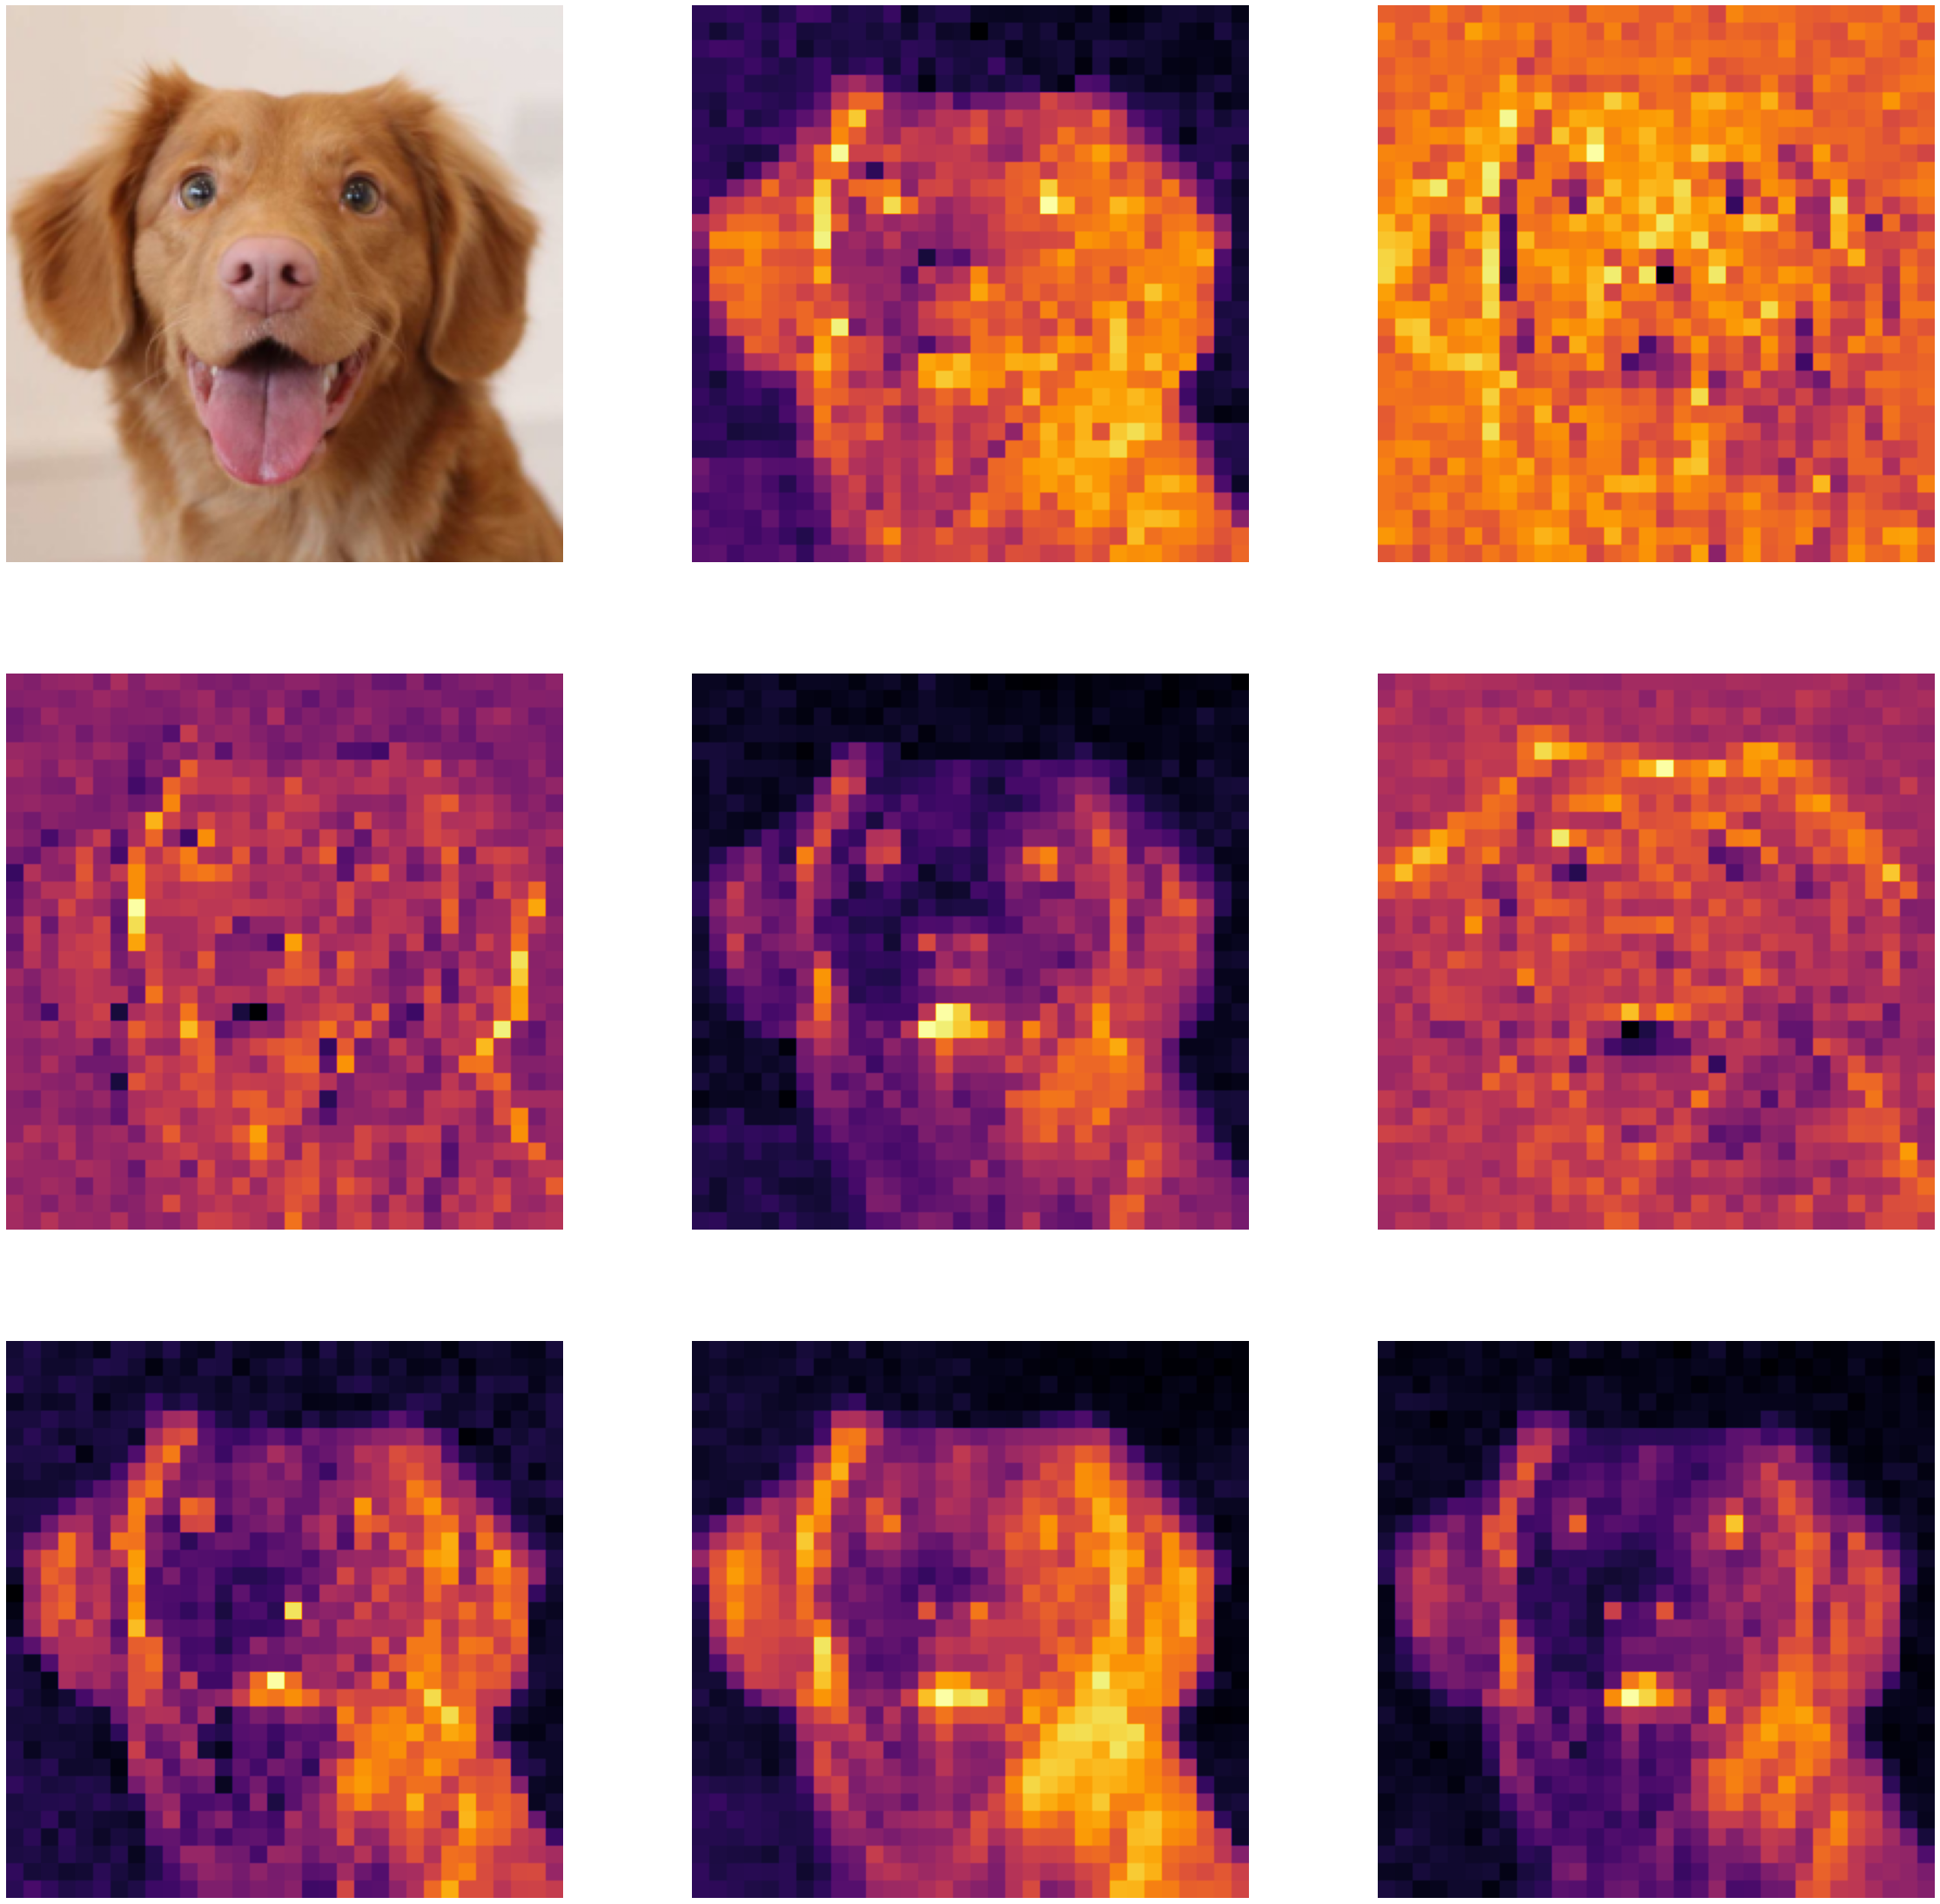

In [25]:
plot_attn('dog.jpg', model=new_dino_model, patch_size=patch_size)

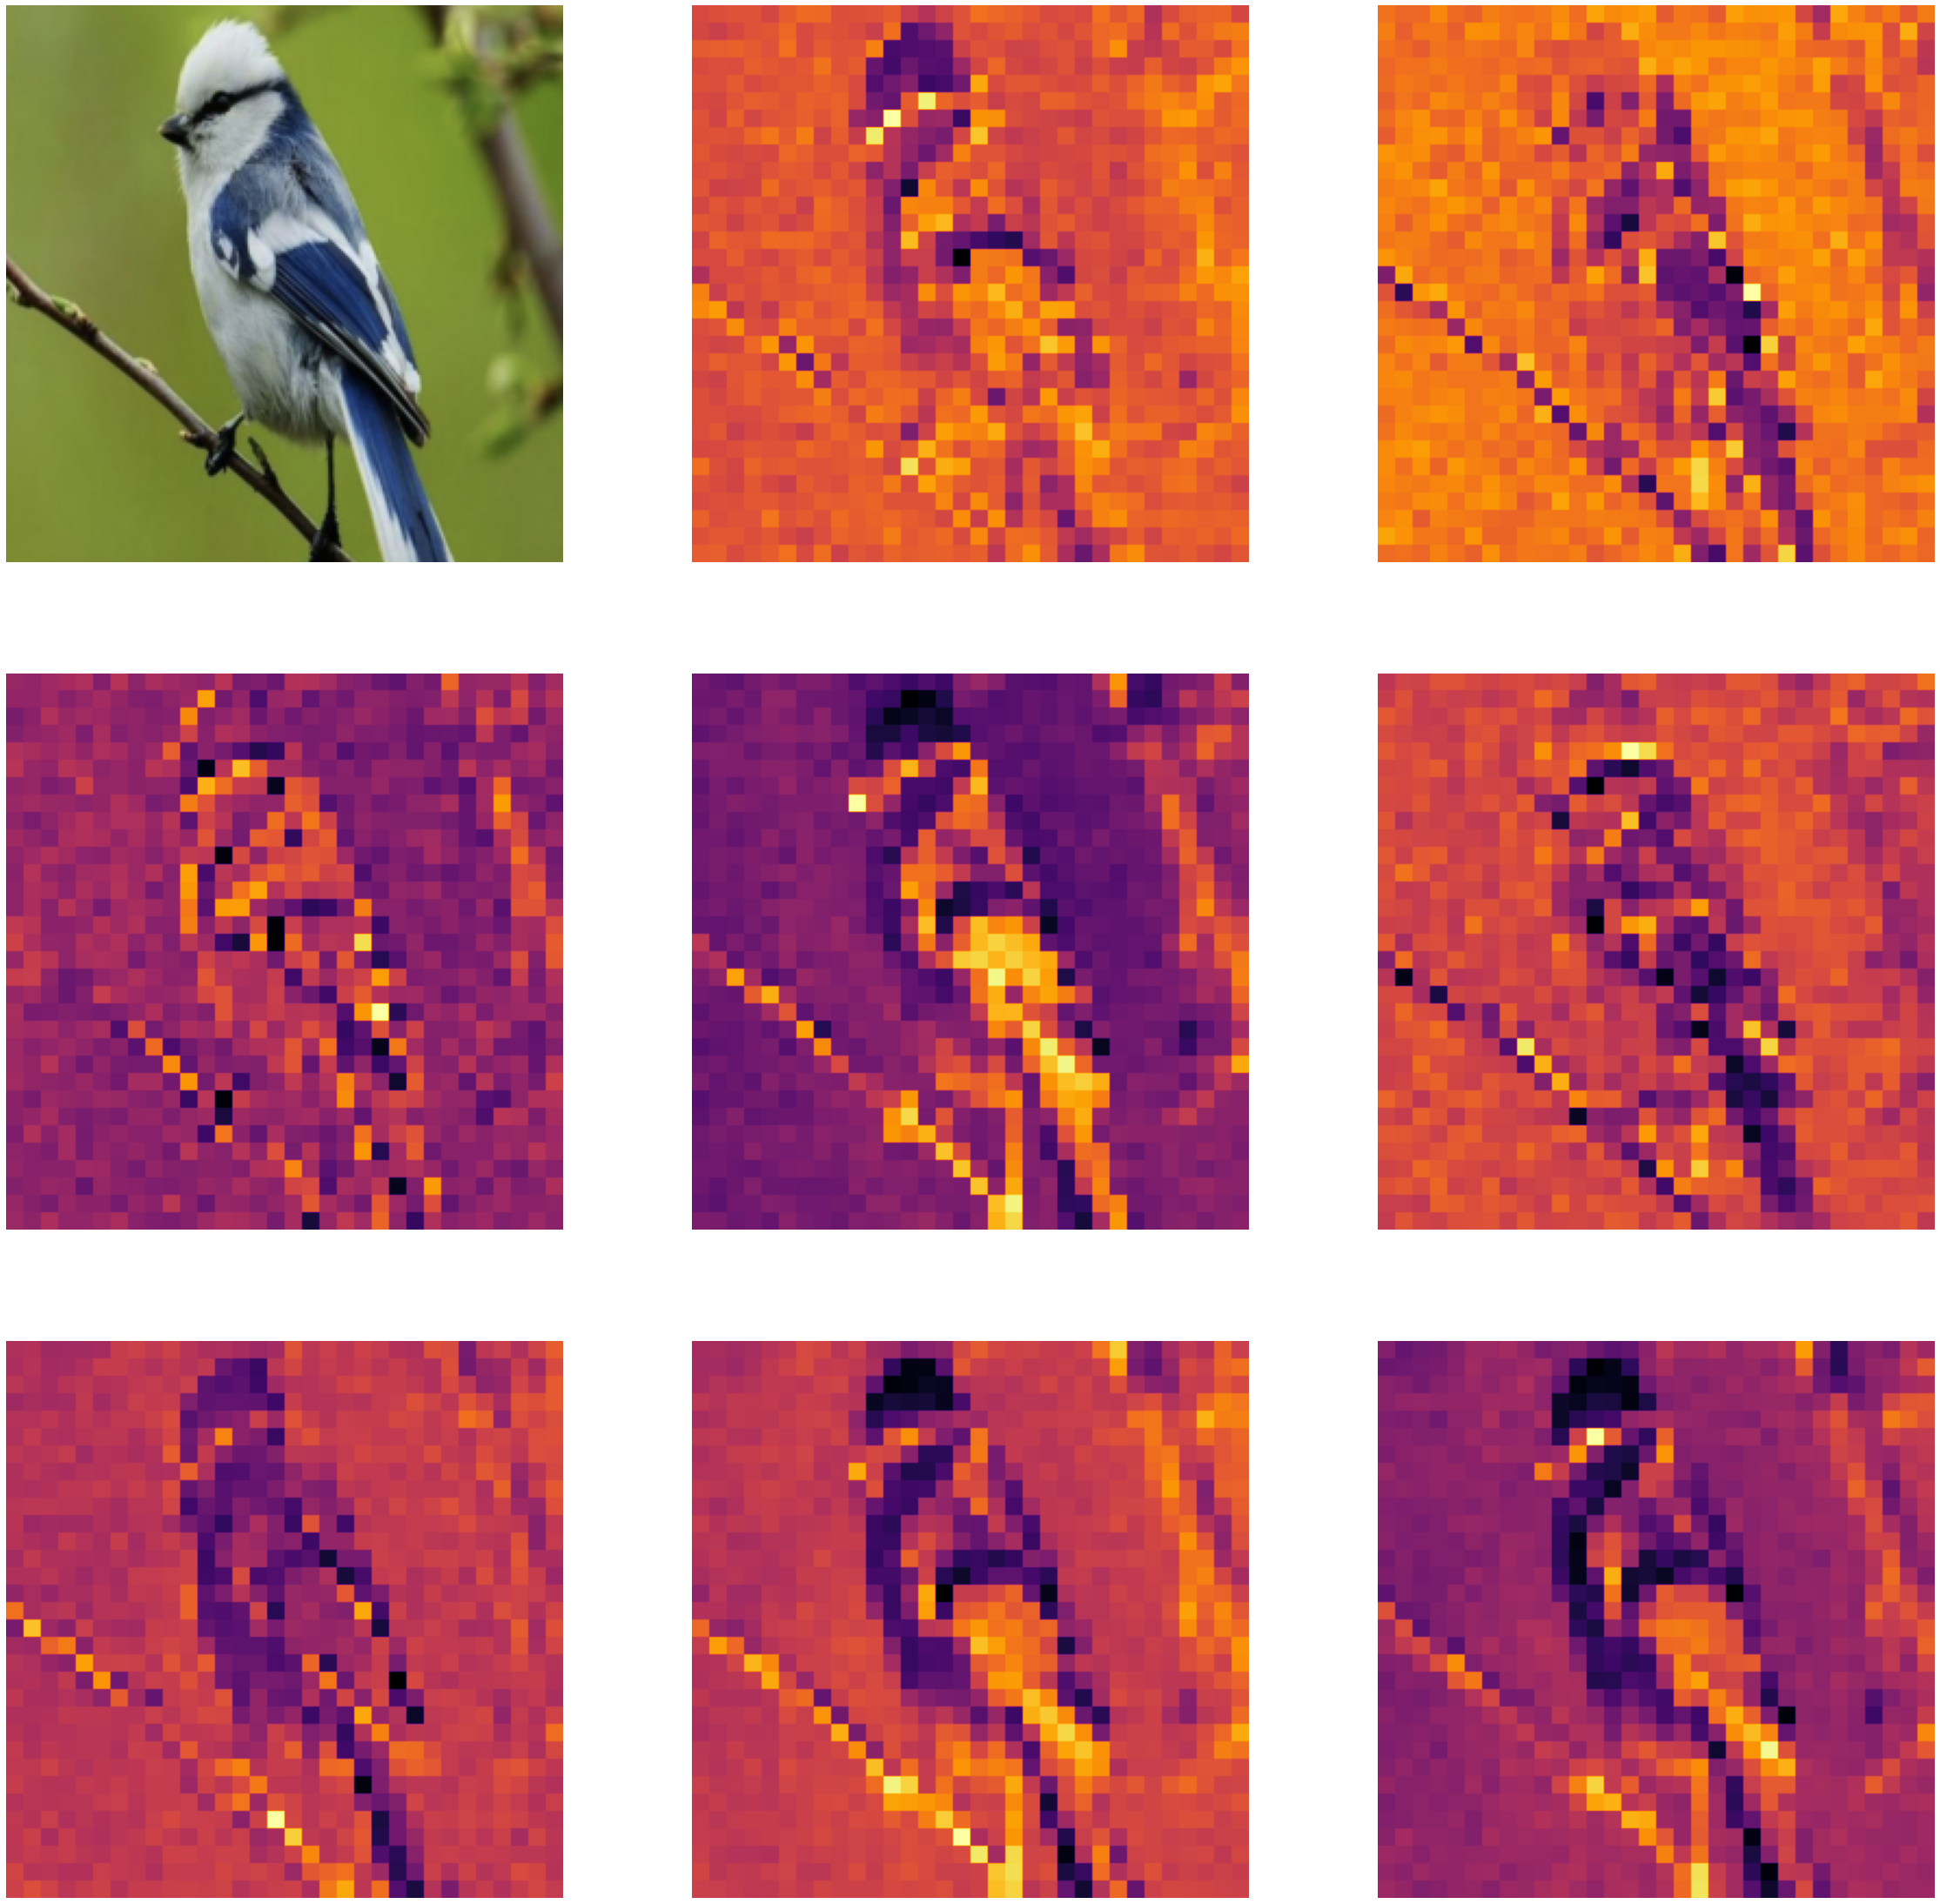

In [26]:
plot_attn('bird.jpg', model=new_dino_model, patch_size=patch_size)

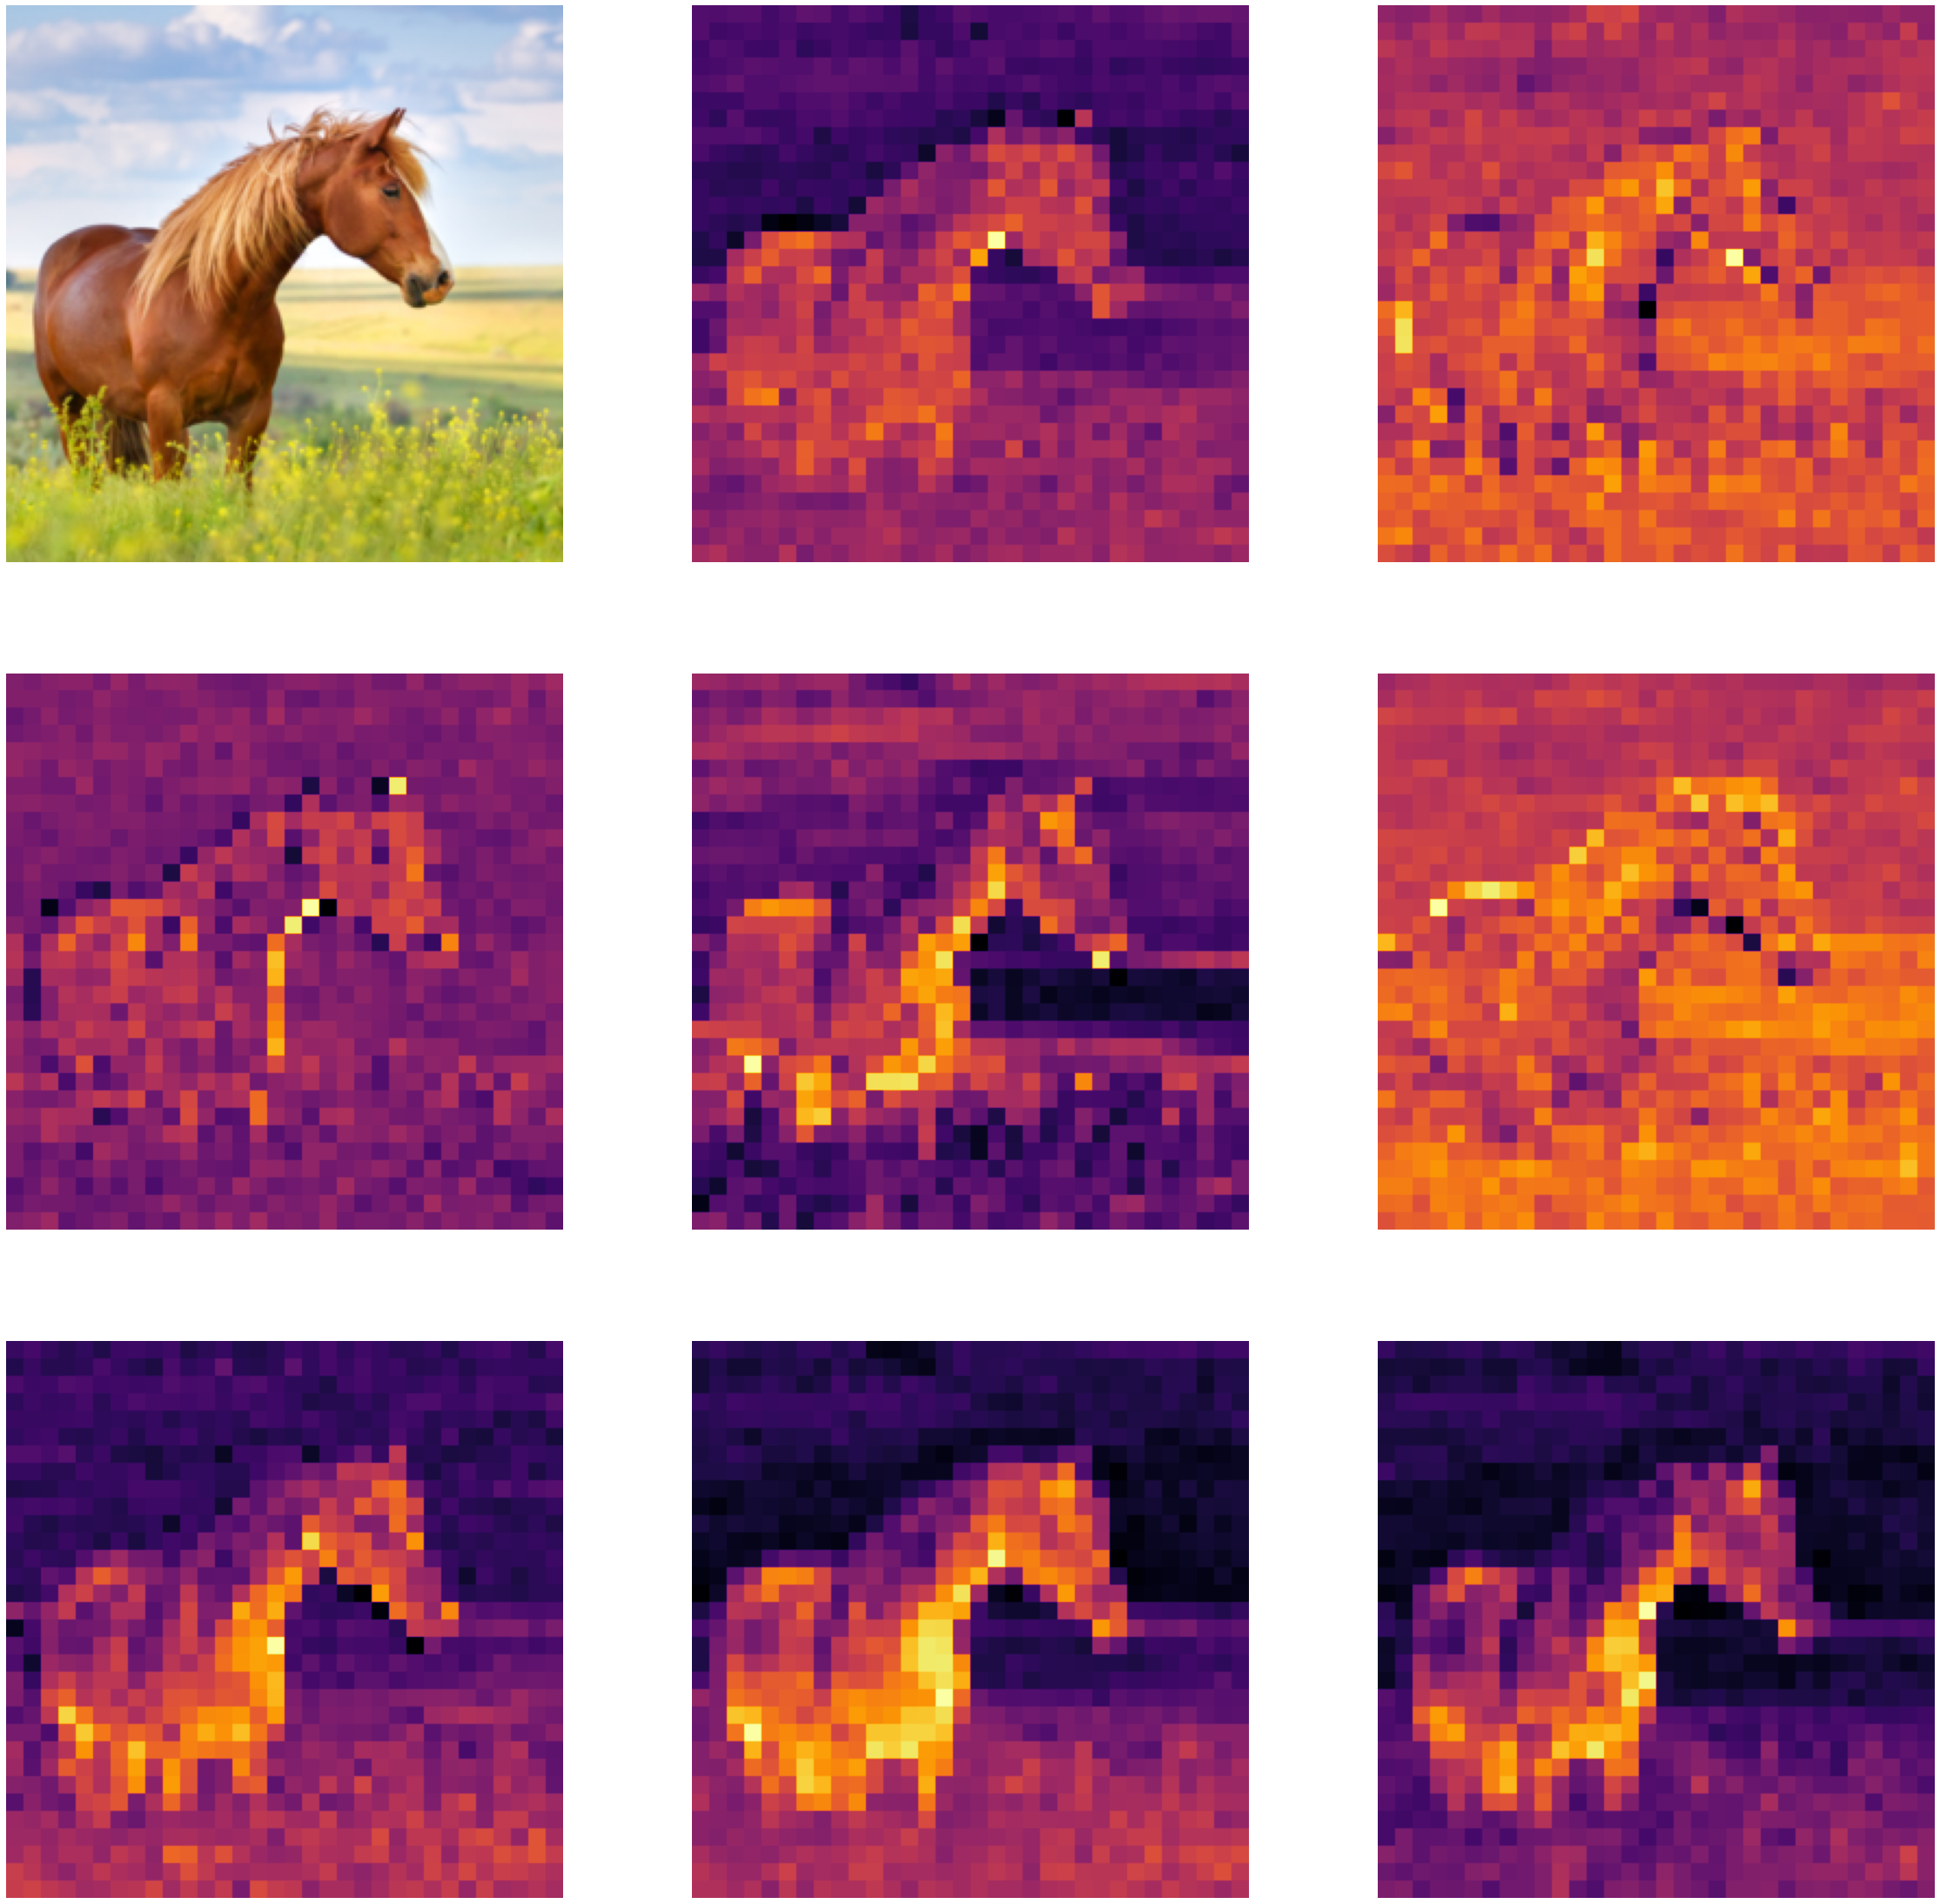

In [27]:
plot_attn('horse.png', model=new_dino_model, patch_size=patch_size)